In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = 16, 12


from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.decomposition import PCA

from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

##### The Sequential Backward Selection algorithm below has been taken from:
Python Machine Learning - By Sebastian Raschka - Chapter 4

In [61]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [2]:
file = 'data/price_data.csv'
data = pd.read_csv(file)

In [3]:
data.head(3)

,Date,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F31,F32,F33,F34,RET5,RET10,RET15,RET20,RET25,RET30
0,2001-11-01,-0.255954,0.844804,1.937538,3.159185,4.345108,0.722899,1.823656,2.916390,4.138037,...,0.015365,0.692678,0.413142,-0.064158,0.088349,0.132201,0.058899,0.152408,0.329321,0.350172
1,2001-11-02,0.450695,1.573175,2.671952,3.916848,5.135008,0.721375,1.843854,2.942632,4.187527,...,0.014769,0.652488,-0.585158,-0.067192,0.054696,0.122536,0.058936,0.158363,0.270935,0.391562
2,2001-11-05,0.807269,1.929457,3.029513,4.294151,5.542462,0.602685,1.724873,2.824930,4.089568,...,0.012211,0.609830,-0.664524,-0.192835,0.123785,0.108787,0.130545,0.136671,0.279045,0.436417


In [4]:
del data['Date']

In [5]:
data.head(3)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F31,F32,F33,F34,RET5,RET10,RET15,RET20,RET25,RET30
0,-0.255954,0.844804,1.937538,3.159185,4.345108,0.722899,1.823656,2.916390,4.138037,5.323961,...,0.015365,0.692678,0.413142,-0.064158,0.088349,0.132201,0.058899,0.152408,0.329321,0.350172
1,0.450695,1.573175,2.671952,3.916848,5.135008,0.721375,1.843854,2.942632,4.187527,5.405687,...,0.014769,0.652488,-0.585158,-0.067192,0.054696,0.122536,0.058936,0.158363,0.270935,0.391562
2,0.807269,1.929457,3.029513,4.294151,5.542462,0.602685,1.724873,2.824930,4.089568,5.337878,...,0.012211,0.609830,-0.664524,-0.192835,0.123785,0.108787,0.130545,0.136671,0.279045,0.436417


In [6]:
# Features are F1 through F34
# Labels are RET5, RET10, RET15, RET20, RET25, RET30

X = data.loc[:,'F1':'F34']
y5 = data.loc[:,'RET5']
y10 = data.loc[:,'RET10']
y15 = data.loc[:,'RET15']
y20 = data.loc[:,'RET20']
y25 = data.loc[:,'RET25']
y30 = data.loc[:,'RET30']

In [7]:
X.head(5)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34
0,-0.255954,0.844804,1.937538,3.159185,4.345108,0.722899,1.823656,2.916390,4.138037,5.323961,...,4.929025,6.439336,-0.275803,3.923116,1.234508,1.005909,0.015365,0.692678,0.413142,-0.064158
1,0.450695,1.573175,2.671952,3.916848,5.135008,0.721375,1.843854,2.942632,4.187527,5.405687,...,4.757539,6.133235,-0.249755,3.937463,1.125941,0.820076,0.014769,0.652488,-0.585158,-0.067192
2,0.807269,1.929457,3.029513,4.294151,5.542462,0.602685,1.724873,2.824930,4.089568,5.337878,...,4.409424,5.762840,-0.336785,3.786531,1.016631,0.622893,0.012211,0.609830,-0.664524,-0.192835
3,0.213114,1.446747,2.576726,3.878652,5.168200,1.264357,2.497991,3.627970,4.929895,6.219444,...,5.091086,5.588416,0.420300,4.575681,0.917630,0.515405,0.017418,0.651869,0.612659,0.213233
4,0.857841,2.147006,3.297188,4.630628,5.958204,0.993181,2.282346,3.432527,4.765968,6.093544,...,4.520432,4.974978,0.223558,4.341133,0.678104,0.179298,0.016032,0.602676,-0.775435,0.206223


In [8]:
#y5.head(5)
#y10.head(5)
#y15.head(5)
#y20.head(5)
#y25.head(5)
y30.head(5)

0    0.350172
1    0.391562
2    0.436417
3    0.309547
4    0.272763
Name: RET30, dtype: float64

In [9]:
X.describe()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34
count,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,...,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000
mean,0.041635,0.111679,0.178834,0.280111,0.427540,0.039720,0.109764,0.176919,0.278196,0.425625,...,1.575420,2.928863,-1.041852,1.261381,0.311590,0.314039,0.000335,0.272544,-0.029297,-0.012391
std,0.519609,1.062366,1.467784,1.991199,2.635561,0.614065,1.141265,1.535689,2.048009,2.681565,...,1.802568,2.330944,1.325197,1.260547,0.849601,0.910676,0.007048,0.162517,0.717866,0.468097
min,-4.393641,-6.269257,-7.200418,-8.298424,-8.810585,-4.856314,-6.731930,-7.464011,-8.081795,-9.004221,...,-2.812682,0.387255,-9.476059,-4.535035,-2.219809,-1.651098,-0.046304,0.068516,-1.000000,-0.821386
25%,-0.188263,-0.345401,-0.467571,-0.601191,-0.692811,-0.230161,-0.388330,-0.510421,-0.646687,-0.734669,...,0.470774,1.419793,-1.475407,0.479439,-0.136847,-0.143327,-0.002752,0.150213,-0.590195,-0.275739
50%,0.038164,0.111062,0.173957,0.254247,0.402023,0.038187,0.113453,0.179115,0.253960,0.386995,...,1.079254,2.286455,-0.776232,0.976823,0.116866,0.102353,0.000275,0.230953,-0.156575,-0.111240
75%,0.277264,0.610762,0.839975,1.165146,1.495615,0.316690,0.636571,0.867979,1.160505,1.491824,...,2.056572,3.592711,-0.296269,1.746482,0.489013,0.510009,0.003678,0.350325,0.368725,0.123437
max,3.007951,5.183313,6.840989,9.487205,12.845803,4.136191,5.773798,7.043611,9.310289,12.624600,...,15.309731,18.343758,4.346298,7.825991,6.161453,8.400022,0.041818,1.233733,4.137424,6.546102


In [10]:
y5.describe()

count    3699.000000
mean        0.003898
std         0.069591
min        -0.469790
25%        -0.030680
50%         0.002907
75%         0.038575
max         0.465792
Name: RET5, dtype: float64

When we plot histograms for each return label we can see that all the returns are approximately normally distributed aroung 0. We can also see that this stock in particular has a positive skew. This conforms with the upward bias in the stock market.

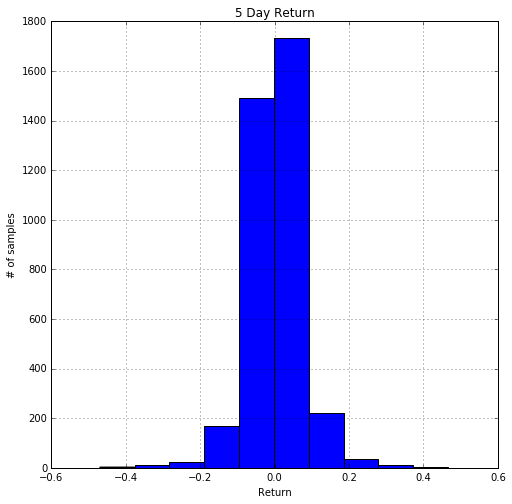

In [11]:
plt.rcParams['figure.figsize'] = 8, 8
y5.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('5 Day Return')
plt.show()

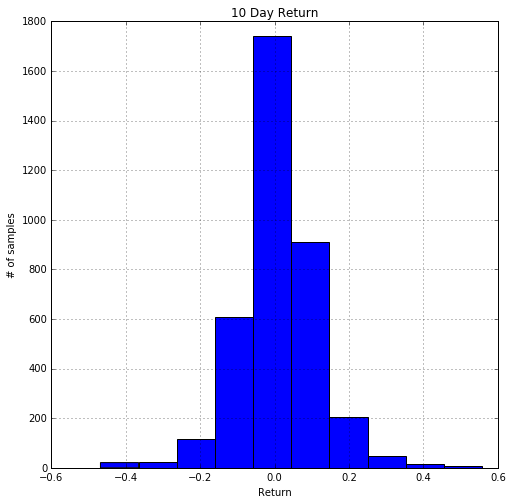

In [12]:
y10.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('10 Day Return')
plt.show()

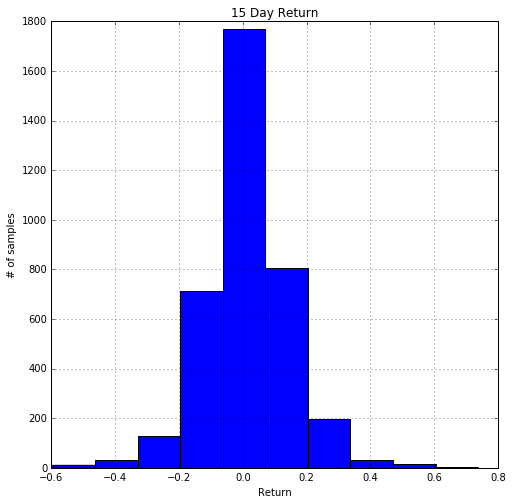

In [13]:
y15.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('15 Day Return')
plt.show()

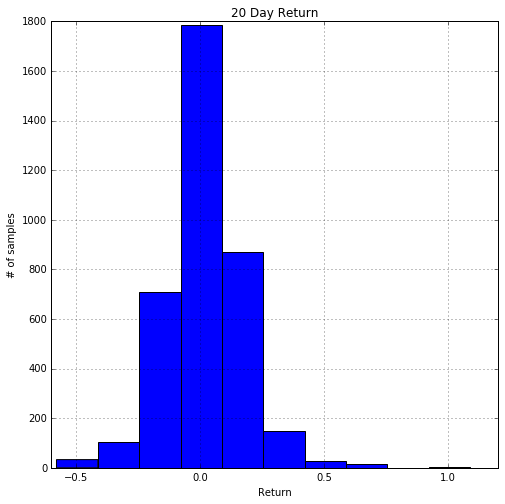

In [14]:
y20.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('20 Day Return')
plt.show()

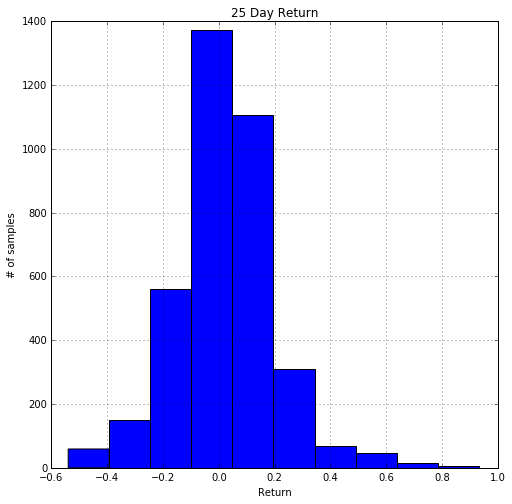

In [15]:
y25.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('25 Day Return')
plt.show()

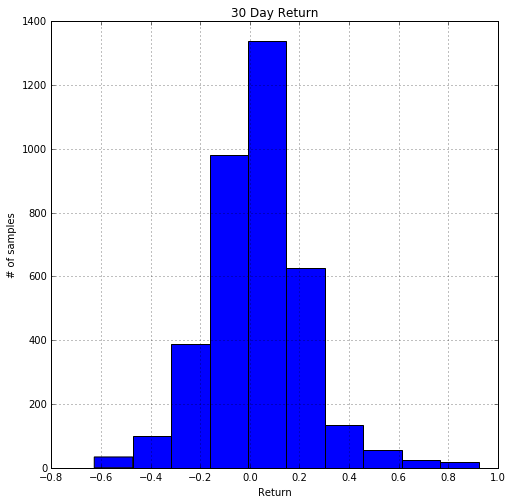

In [16]:
y30.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('30 Day Return')
plt.show()

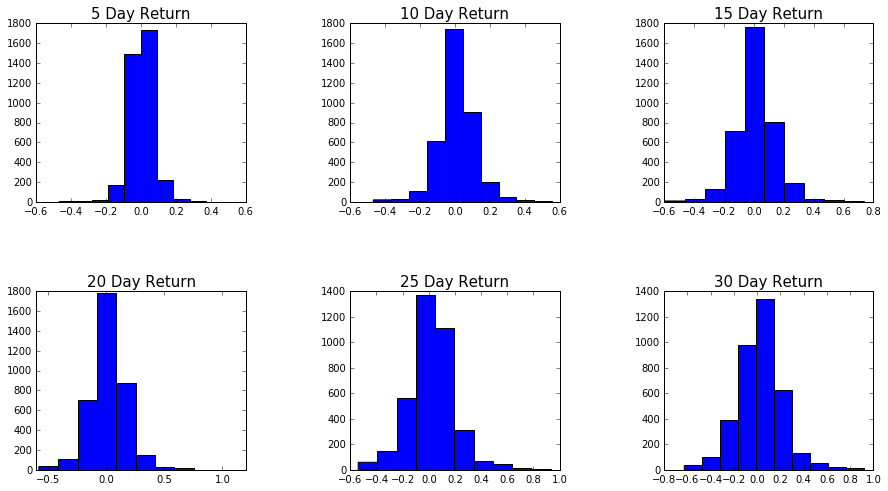

In [17]:
plt.rcParams['figure.figsize'] = 15, 8
fig, axes = plt.subplots(2,3, sharex=False, sharey=False)

axes[0,0].hist(y5)
axes[0,0].set_title('5 Day Return', fontsize=15)

axes[0,1].hist(y10)
axes[0,1].set_title('10 Day Return', fontsize=15)

axes[0,2].hist(y15)
axes[0,2].set_title('15 Day Return', fontsize=15)

axes[1,0].hist(y20)
axes[1,0].set_title('20 Day Return', fontsize=15)

axes[1,1].hist(y25)
axes[1,1].set_title('25 Day Return', fontsize=15)

axes[1,2].hist(y30)
axes[1,2].set_title('30 Day Return', fontsize=15)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

### Phase 1
In the first phase of model building we will start with the simplest label grouping. We will separate our labels into either positive, or negative returns. This will give us two classes with approximately equal class distributions.

In [18]:
y5.columns = ['RET']
y10.columns = ['RET']
y15.columns = ['RET']
y20.columns = ['RET']
y25.columns = ['RET']
y30.columns = ['RET']

In [19]:
def binary_class(row):
    if row < 0.00:
        return 0
    else:
        return 1

In [20]:
y5_b = pd.Series(index=y5.index)
y10_b = pd.Series(index=y5.index)
y15_b = pd.Series(index=y5.index)
y20_b = pd.Series(index=y5.index)
y25_b = pd.Series(index=y5.index)
y30_b = pd.Series(index=y5.index)

y5_b = y5.apply(binary_class)
y10_b = y10.apply(binary_class)
y15_b = y15.apply(binary_class)
y20_b = y20.apply(binary_class)
y25_b = y25.apply(binary_class)
y30_b = y30.apply(binary_class)

In [21]:
y25_b.head(5)

0    1
1    1
2    1
3    1
4    1
Name: RET25, dtype: int64

In [22]:
plt.rcParams['figure.figsize'] = 8, 8

Looking at the binary classification results, we can see that separating the class labels based on negative and positive returns, gives us an approximately equal distribution for each class.

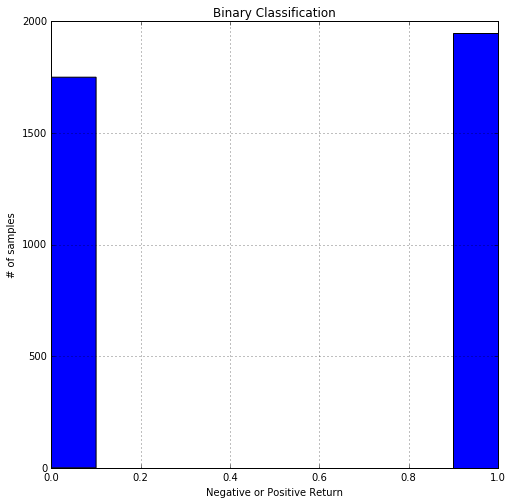

In [23]:
y5_b.hist()
plt.xlabel('Negative or Positive Return')
plt.ylabel('# of samples')
plt.title('Binary Classification')
plt.show()

### Phase 2
In this phase we will increase the number of boundaries from one to two. From a trading standpoint, we want to stay away from trades that return close to 0% return. We do want to identify trades that have substantial return.

We can define substantial return as > 2% or 0.02 or < -2% or -0.02
Class boundaries:
label 0: <=-0.02
label 1: >-0.02 and < 0.02
label 2: >= 0.02

Another way to find out what the boundary should be is to look at the class distributions that result from a particular boundary. The boundary can then be changed to ensure that the distribution becomes approximately equal for all classes. You may find that you have to use different boundaries for different returns.

In [24]:
def update_return_class(row, neg_cutoff, pos_cutoff):
    if row <= neg_cutoff:
        return 0
    elif row > neg_cutoff and row < pos_cutoff:
        return 1
    elif row >= pos_cutoff:
        return 2

In [25]:
y5_t = pd.Series(index=y5.index)
y10_t = pd.Series(index=y5.index)
y15_t = pd.Series(index=y5.index)
y20_t = pd.Series(index=y5.index)
y25_t = pd.Series(index=y5.index)
y30_t = pd.Series(index=y5.index)

y5_t = y5.apply(update_return_class, args=(-0.02, 0.02))
y10_t = y10.apply(update_return_class, args=(-0.03, 0.03))
y15_t = y15.apply(update_return_class, args=(-0.05, 0.05))
y20_t = y20.apply(update_return_class, args=(-0.05, 0.05))
y25_t = y25.apply(update_return_class, args=(-0.05, 0.07))
y30_t = y30.apply(update_return_class, args=(-0.05, 0.08))

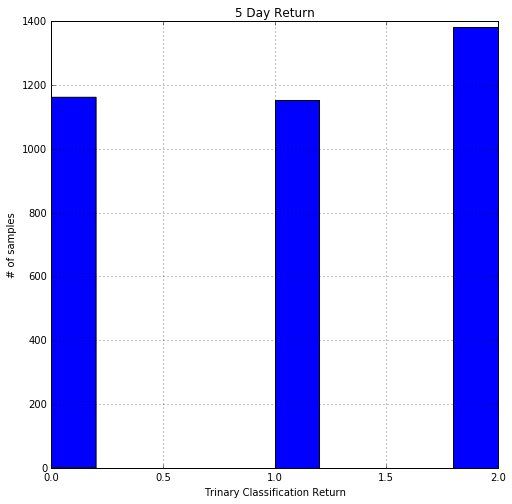

In [26]:
y5_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('5 Day Return')
plt.show()

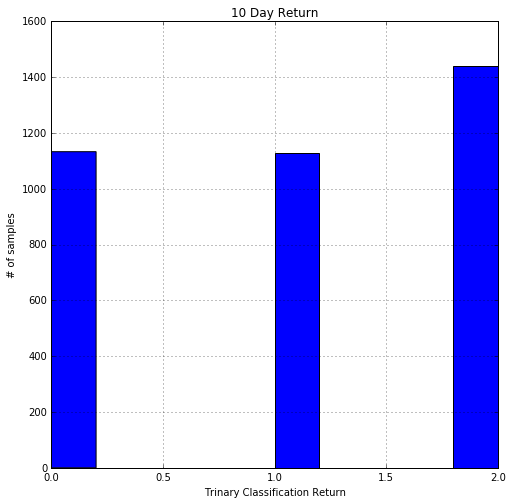

In [27]:
y10_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('10 Day Return')
plt.show()

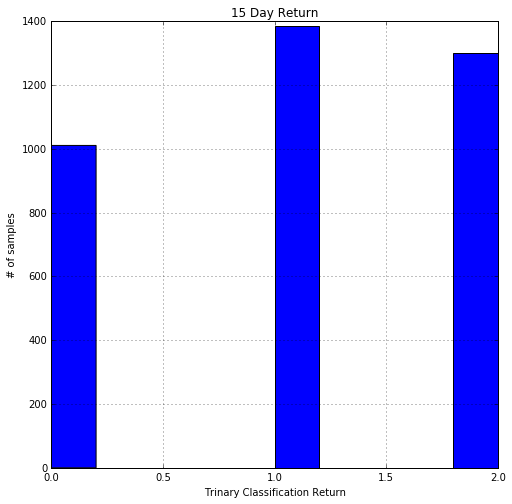

In [28]:
y15_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('15 Day Return')
plt.show()

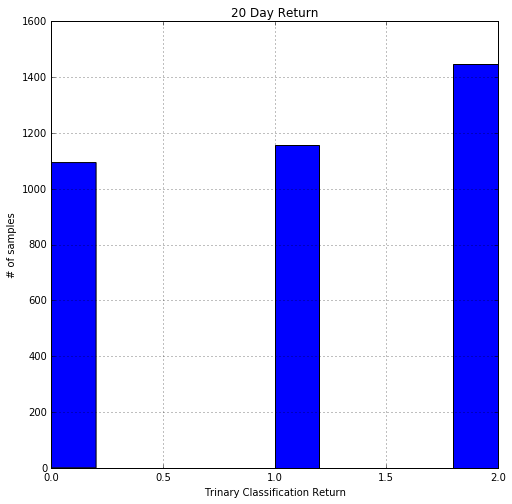

In [29]:
y20_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('20 Day Return')
plt.show()

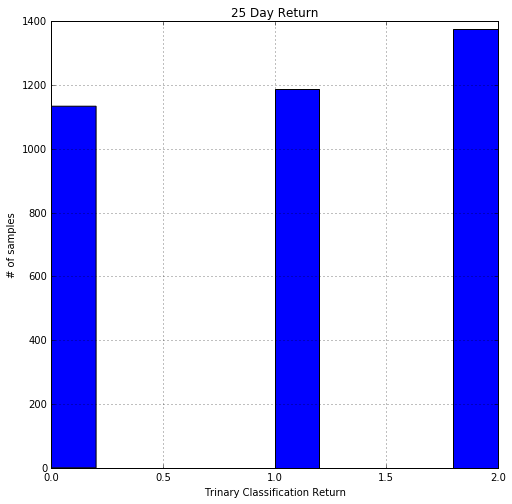

In [30]:
y25_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('25 Day Return')
plt.show()

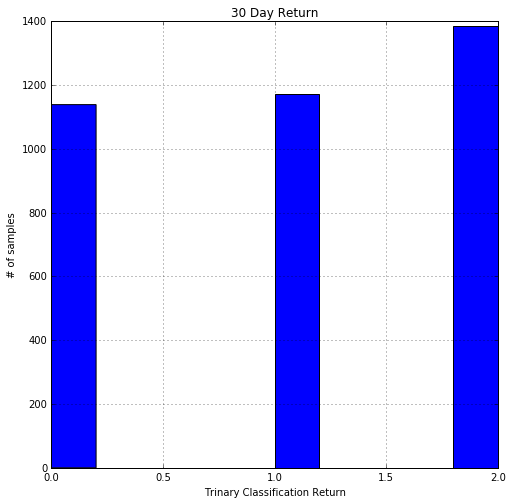

In [31]:
y30_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('30 Day Return')
plt.show()

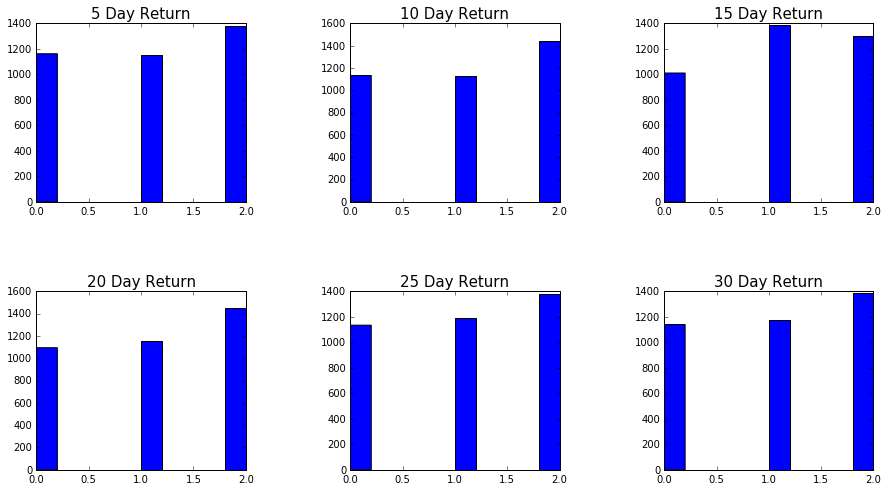

In [32]:
plt.rcParams['figure.figsize'] = 15, 8
fig, axes = plt.subplots(2,3, sharex=False, sharey=False)

axes[0,0].hist(y5_t)
axes[0,0].set_title('5 Day Return', fontsize=15)

axes[0,1].hist(y10_t)
axes[0,1].set_title('10 Day Return', fontsize=15)

axes[0,2].hist(y15_t)
axes[0,2].set_title('15 Day Return', fontsize=15)

axes[1,0].hist(y20_t)
axes[1,0].set_title('20 Day Return', fontsize=15)

axes[1,1].hist(y25_t)
axes[1,1].set_title('25 Day Return', fontsize=15)

axes[1,2].hist(y30_t)
axes[1,2].set_title('30 Day Return', fontsize=15)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

### Testing and Validation Strategy
We will be using multi-pronged testing strategy
1) Use k-fold cross-validation
2) Use continuous samples as training data and test on future data
3) Use sliding window continuous training and test data

In [46]:
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, y10_b, test_size=validation_size, 
                                                                                 random_state=seed)

In [47]:
# Evaluate Algorithms
# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
seed = 7
scoring = 'accuracy'

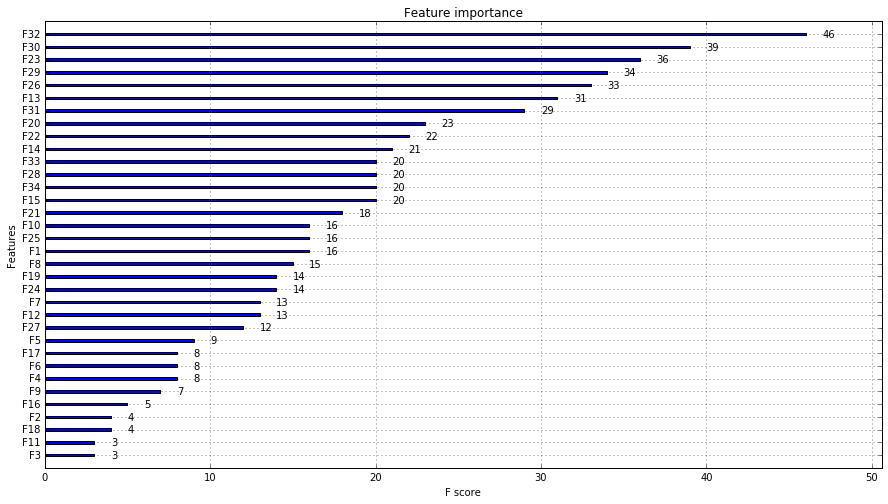

In [59]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
Y_pred = xgb.predict(X_validation)
plot_importance(xgb)


rf = RandomForestClassifier()
et = ExtraTreesClassifier()
# Remove Age and Sex from the training data
# Once we do, person jumps up to 2nd place in importance
#xgb_per = XGBClassifier()
#X_train_per = X_train.drop(['Age','Sex'], axis=1)
#X_validation_per = X_validation.drop(['Age','Sex'], axis=1)
#xgb_per.fit(X_train_per, Y_train)
#Y_pred = xgb_per.predict(X_validation_per)
#plot_importance(xgb_per)

plt.show()

In [49]:
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(y10_b,10), scoring='accuracy')
rfecv.fit(X,y10_b)

RFECV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 1 1], n_folds=10, shuffle=False, random_state=None),
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   estimator_params=None, scoring='accuracy', step=1, verbose=0)

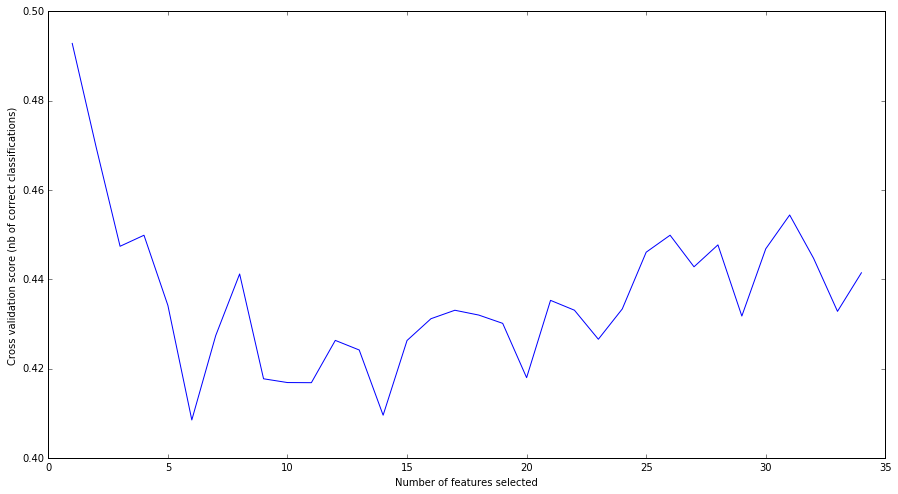

In [50]:
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [51]:
print(rfecv.ranking_)

[26 34 13 33 31 30 23 32 21  5 28 24 19 16 10 27 17 12  3  1  6  2 15 22 18
  4 20 14  9  8 11  7 29 25]


In [52]:
print(rfecv.support_)

[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False]


In [53]:
print(rfecv.n_features_)

1


In [54]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())])))
ensembles.append(('ScaledXGB', Pipeline([('Scaler', StandardScaler()),('XGB', XGBClassifier())])))
results = []
names = []
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
for name, model in ensembles:
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: 0.617100 (0.020494)
ScaledGBM: 0.660358 (0.015711)
ScaledRF: 0.709038 (0.026396)
ScaledET: 0.734378 (0.019548)
ScaledXGB: 0.650551 (0.015942)


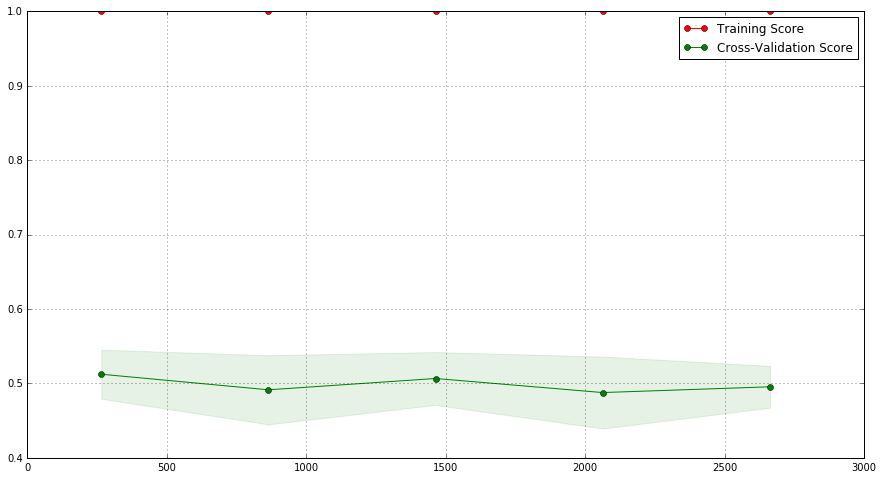

In [55]:
plt.figure()
model = Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())])
train_sizes, train_scores, test_scores = learning_curve(model, X, y5_b, cv=kfold, n_jobs=1, train_sizes=np.linspace(.1,1.0,5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
plt.legend(loc="best")
plt.show()

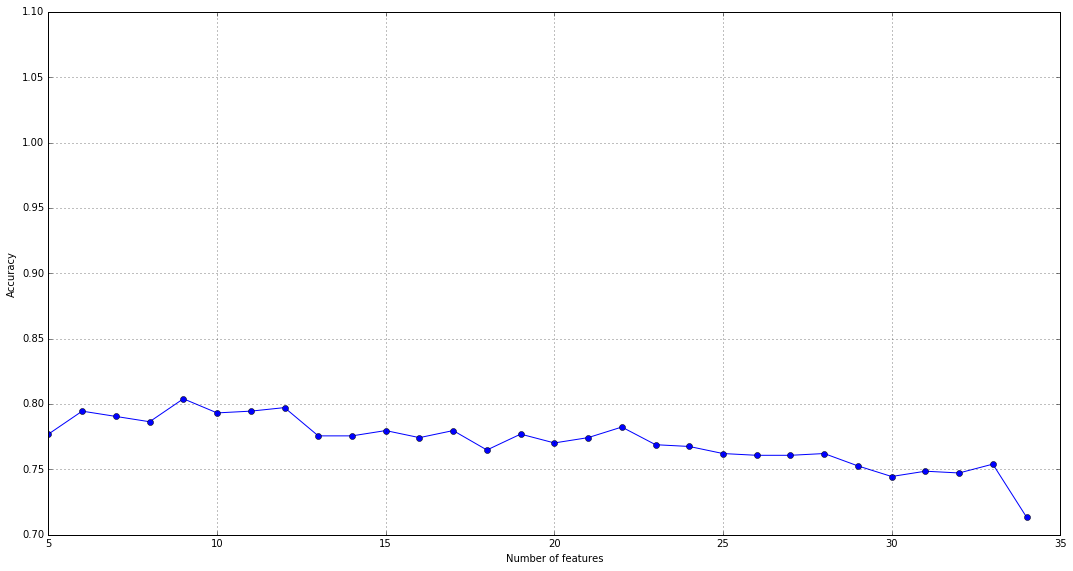

In [72]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_validation)
    
et = ExtraTreesClassifier()

# selecting features
sbs = SBS(et, k_features=5)
sbs.fit(X_train_std, Y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [83]:
k5 = list(sbs.subsets_[10])
print(X.columns[1:][k5])
#print(k5)

Index(['F2', 'F5', 'F6', 'F7', 'F10', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18',
       'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F27', 'F28', 'F29', 'F30',
       'F31', 'F32', 'F33'],
      dtype='object')


In [84]:
et.fit(X_train_std, Y_train)
print('Training accuracy:', et.score(X_train_std, Y_train))
print('Test accuracy:', et.score(X_test_std, Y_validation))

Training accuracy: 1.0
Test accuracy: 0.718918918919


In [85]:
et.fit(X_train_std[:, k5], Y_train)
print('Training accuracy:', et.score(X_train_std[:, k5], Y_train))
print('Test accuracy:', et.score(X_test_std[:, k5], Y_validation))

Training accuracy: 1.0
Test accuracy: 0.767567567568
